In [1]:
from fastai.vision.all import *

In [2]:
%pip install gdown

   ---------------------------------------- 0.0/147.9 kB ? eta -:--:--
   -------- ------------------------------- 30.7/147.9 kB 1.4 MB/s eta 0:00:01
   ---------------- ---------------------- 61.4/147.9 kB 825.8 kB/s eta 0:00:01
   ------------------------------ --------- 112.6/147.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 147.9/147.9 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
url = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [4]:
!gdown {url}

Downloading...
From (original): https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z
From (redirected): https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z&confirm=t&uuid=ba95916b-c95a-41fa-8533-358110f94cf6
To: c:\Users\kevol\Desktop\DL Python\fastai_rep\Portrait.zip

  0%|          | 0.00/107M [00:00<?, ?B/s]
  0%|          | 524k/107M [00:00<00:34, 3.09MB/s]
  2%|▏         | 2.62M/107M [00:00<00:09, 10.9MB/s]
  6%|▋         | 6.82M/107M [00:00<00:04, 22.6MB/s]
  9%|▉         | 9.44M/107M [00:00<00:04, 19.6MB/s]
 11%|█         | 12.1M/107M [00:00<00:05, 17.2MB/s]
 13%|█▎        | 14.2M/107M [00:00<00:06, 13.8MB/s]
 17%|█▋        | 17.8M/107M [00:01<00:04, 18.5MB/s]
 19%|█▉        | 20.4M/107M [00:01<00:05, 16.1MB/s]
 23%|██▎       | 24.6M/107M [00:01<00:03, 20.9MB/s]
 25%|██▌       | 27.3M/107M [00:01<00:03, 21.2MB/s]
 28%|██▊       | 29.9M/107M [00:01<00:05, 13.6MB/s]
 31%|███       | 33.6M/107M [00:01<00:04, 17.4MB/s]
 34%|███▎      | 36.2M/107M [00:02<00:0

In [5]:
from zipfile import ZipFile

with ZipFile("Portrait.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [6]:
path = Path("data")

In [7]:
for walk in path.ls():
    print(repr(walk), walk.is_file())

Path('data/EG1800_train.txt') True
Path('data/EG1800_val.txt') True
Path('data/GT_png') False
Path('data/images_data_crop') False
Path('data/train.txt') True
Path('data/val.txt') True


In [8]:
(path/"GT_png").ls()[0]

Path('data/GT_png/00001_mask.png')

In [9]:
mask = Image.open((path/"GT_png").ls()[0])

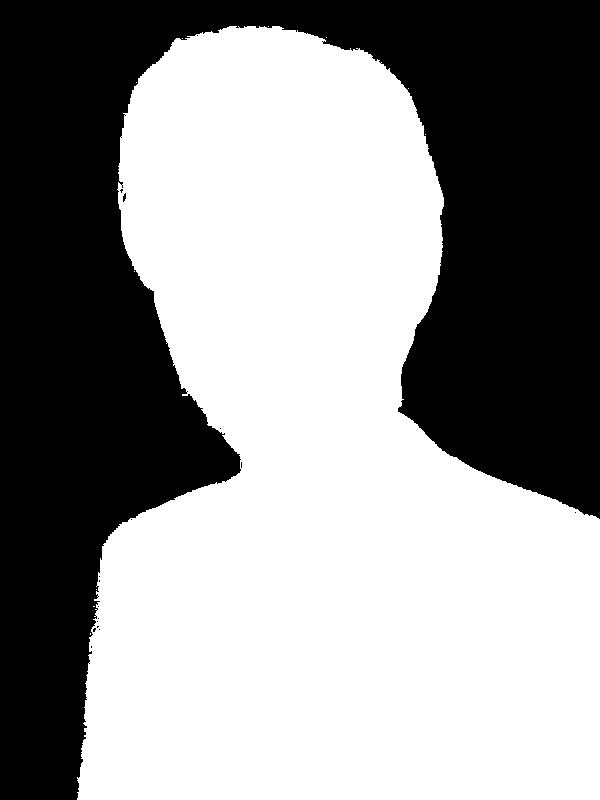

In [10]:
mask

In [11]:
mask = np.asarray(mask); mask

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [12]:
def get_codes(fnames) -> Dict[int,int]: 
    "Returns a dictionary of `original_code:new_code` for pixel values in segmentation masks"
    unique_codes = set()
    for fname in fnames:
        mask = Image.open(fname)
        mask = np.asarray(mask)
        for color in np.unique(mask):
            unique_codes.add(color)
    return {
        i : color
        for i, color in 
        enumerate(unique_codes)
    }

In [13]:
unique_codes = get_codes((path/"GT_png").ls()[:20])
unique_codes

{0: 0, 1: 255}

In [14]:
mask = mask.copy()
np.place(mask, mask==255, 1)
np.unique(mask)

array([0, 1], dtype=uint8)

In [15]:
codes = ["Background", "Face"]
blocks = (ImageBlock, MaskBlock(codes=codes))

In [16]:
unique_codes

{0: 0, 1: 255}

In [17]:
def get_y(filename:Path, unique_codes:dict):
    "Grabs a mask from `filename` and adjusts the pixel values based on `unique_codes`"
    filename = path/"GT_png"/f'{filename.stem}_mask.png'
    mask = np.asarray(Image.open(filename)).copy()
    for new_value, old_value in unique_codes.items():
        np.place(mask, mask==old_value, new_value)
    return PILMask.create(mask)

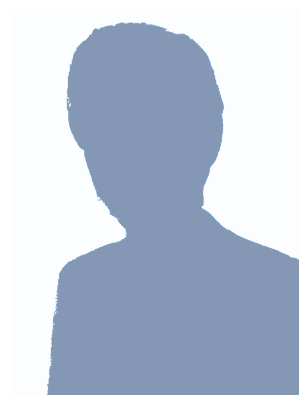

In [18]:
new_mask = get_y((path/"images_data_crop").ls()[0], unique_codes)
new_mask.show(cmap="Blues");

In [19]:
block = DataBlock(
    blocks=blocks,
    splitter=RandomSplitter(),
    get_y=partial(get_y, unique_codes=unique_codes),
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

In [20]:
dls = block.dataloaders(
    get_image_files(path/'images_data_crop'), 
    bs=8
)

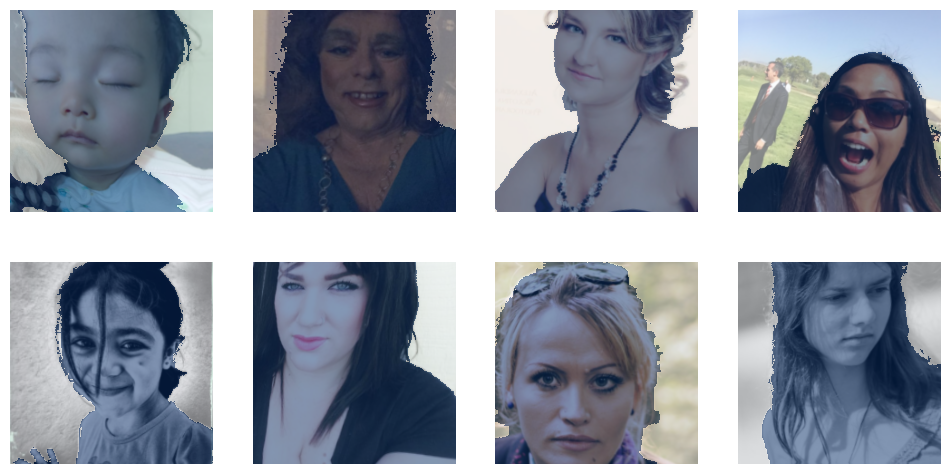

In [21]:
dls.show_batch(cmap="Blues", vmin=0, vmax=1)

In [22]:
splitter = RandomSplitter()
dsets = Datasets(
    get_image_files(path/'images_data_crop'),
    tfms=[
        [PILImage.create], 
        [partial(get_y, unique_codes=unique_codes)]
    ],
    splits = splitter(get_image_files(path/'images_data_crop'))
)

In [23]:
dls = dsets.dataloaders(
    after_item = [
        Resize(224), 
        ToTensor(), 
        AddMaskCodes(codes=codes)
    ],
    after_batch = [
        *aug_transforms(), 
        IntToFloatTensor(), 
        Normalize.from_stats(*imagenet_stats)
    ],
    bs=8
)

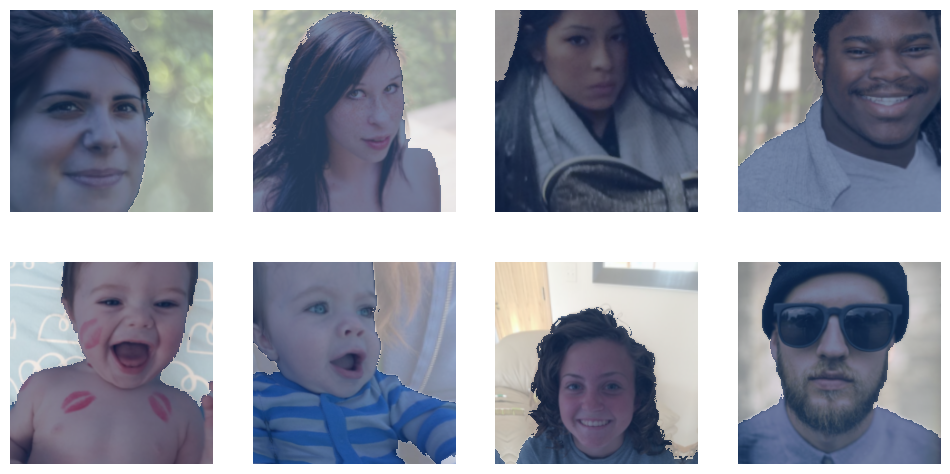

In [24]:
dls.show_batch(cmap="Blues", vmin=0, vmax=1)

In [25]:
learn = unet_learner(
    dls, 
    resnet34, 
    metrics=partial(accuracy, axis=1), 
    self_attention=True, 
    act_cls=Mish,
    loss_func = CrossEntropyLossFlat(axis=1)
)

In [26]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [27]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.171965,0.279325,0.879008,01:58
1,0.141409,0.164926,0.949110,01:40
2,0.148569,0.259506,0.905229,01:40
3,0.109494,0.078214,0.973517,01:42
4,0.088535,0.074008,0.973122,01:42
5,0.080887,0.075058,0.973468,01:41
6,0.069690,0.065602,0.976233,01:41
7,0.061729,0.064728,0.977099,01:40
8,0.058175,0.062048,0.977639,01:39
9,0.058887,0.060927,0.977891,01:40


In [30]:
learn.save("stage_3_1")
#learn.load("stage_3_1")

Path('models/stage_3_1.pth')

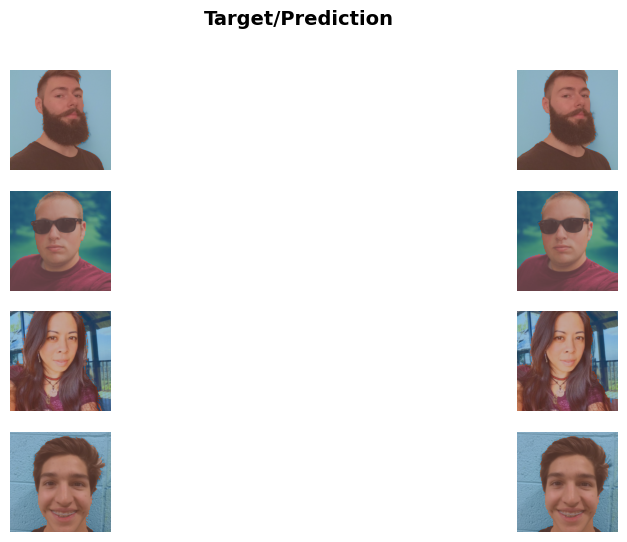

In [31]:
learn.show_results(max_n=4, figsize=(12,6))

In [32]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/400, 1e-3/4))

epoch,train_loss,valid_loss,accuracy,time
0,0.060179,0.066923,0.977076,02:00
1,0.060575,0.062745,0.977913,01:50
2,0.053453,0.062012,0.978028,01:47
3,0.050938,0.059804,0.978843,01:48


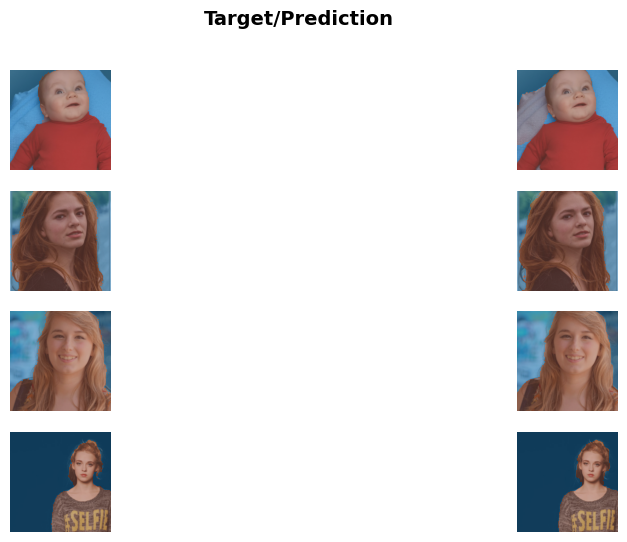

In [33]:
learn.show_results(max_n=4, figsize=(12,6))

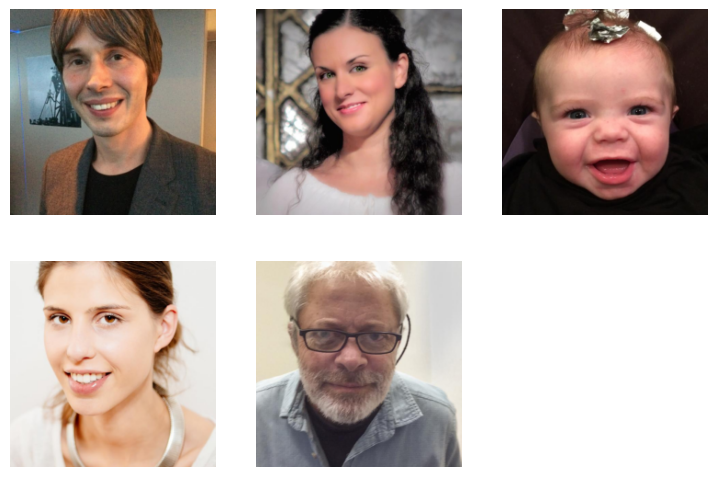

In [34]:
dl = learn.dls.test_dl(
    (path/'images_data_crop').ls()[:5]
)
dl.show_batch()

In [35]:
preds = learn.get_preds(dl=dl)

In [36]:
preds[0].shape

torch.Size([5, 2, 224, 224])

In [37]:
preds[0][0].shape

torch.Size([2, 224, 224])

In [38]:
pred = preds[0][0].argmax(dim=0)

In [39]:
pred.shape

torch.Size([224, 224])

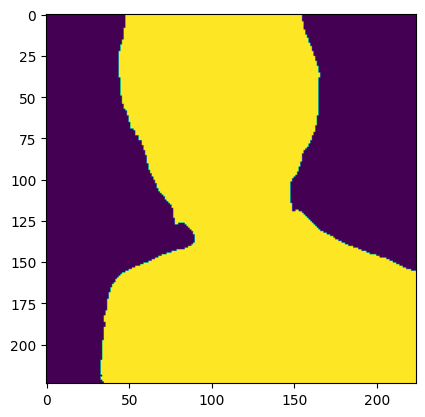

In [40]:
plt.imshow(pred);

In [41]:
pred = pred.numpy()
rescaled = (255.0 / pred.max() * (pred - pred.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
im.save("mask.png")

In [42]:
fnames = (path/'images_data_crop').ls()[:5]

item_tfms = Pipeline([
    PILImage.create, 
    RandomResizedCrop(224), 
    ToTensor()
], split_idx=1)

batch_tfms = Pipeline([
    IntToFloatTensor(), 
    Normalize.from_stats(*imagenet_stats)
])

batch = []
for fname in fnames:
    batch.append(item_tfms(fname))
batch = torch.stack(batch, dim=0)
batch = batch_tfms(batch.cuda())

model = learn.model
model.eval()

with torch.no_grad():
    preds = model(batch)

for i,pred in enumerate(preds):
    pred = pred.argmax(0)
    pred = pred.cpu().numpy()
    rescaled = (255.0 / pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(f'pred_{i}.png')